In [1]:
import logging
from NuRadioReco.utilities.logging import set_general_log_level

import argparse
#import time
import datetime
import numpy as np
import matplotlib.pyplot as plt

from NuRadioReco.modules.io.coreas import coreas
# import NuRadioReco.modules.LOFAR.hardwareResponseIncorporator
import NuRadioReco.modules.channelGalacticNoiseAdder
import NuRadioReco.modules.channelGenericNoiseAdder
import NuRadioReco.modules.channelResampler
import NuRadioReco.modules.efieldToVoltageConverter
import NuRadioReco.modules.io.coreas
import NuRadioReco.modules.io.coreas.readCoREASDetector
from NuRadioReco.detector import detector
from NuRadioReco.modules import voltageToEfieldConverter
import NuRadioReco.modules.io.eventWriter
from NuRadioReco.framework.parameters import stationParameters, channelParameters, showerParameters
from NuRadioReco.utilities import units
from astropy import time
from NuRadioReco.framework.parameters import showerParameters as shp

 # Set log level of this script
set_general_log_level(logging.WARNING)  # Setup general logging level (before imports to get nice formatting everywhere)


lowfreq = 50 * units.MHz
highfreq = 80 * units.MHz

# input file
# filename = '/home/plaub/Documents/ska-pev-gamma/ska-pev/data/SIM000001.hdf5'
filename = '/home/denis/radio_nn/HDF5_vs_PREDICTED/original/259787063/0/proton/SIM000375.hdf5'
nur_filename = 'nur_files/test'
save_nur = True
sampling_rate = 1 * units.GHz

dezimation = 8
core_list = [np.array([0, 0, 7.6])]

long_trace = False
caching_efVT = True
caching_cGNA = True

# load detector:
det = detector.Detector("LOFAR/LOFAR.json", source="json", antenna_by_depth=False)
det.update(time.Time("2023-01-01T00:00:00", format='isot', scale='utc'))

selected_station_channel_ids = {}
for staid in det.get_station_ids():
    selected_station_channel_ids[staid] = np.sort(np.concatenate([det.get_channel_ids(staid)[0::2][::dezimation], 
                                                                  det.get_channel_ids(staid)[1::2][::dezimation]])) #select every [dezimation]th antenna, but keep channel pairs

# resample to 1 GHz
resampler = NuRadioReco.modules.channelResampler.channelResampler()
resampler.begin()

# Initialise GalacticNoiseAdder
# Choose sky model. Options: lfmap, lfss, gsm2016, gsm2008, haslam, ssm, gmoss, ulsa_fdi, ulsa_dpi, ulsa_ci.
# If you can and have it installed, use LFmap. otherwise, use gsm2008/2016
channelGalacticNoiseAdder = NuRadioReco.modules.channelGalacticNoiseAdder.channelGalacticNoiseAdder()
channelGalacticNoiseAdder.begin(
    skymodel='lfmap',
    caching=caching_cGNA
)

# Initialise GenericNoiseAdder
channelGenericNoiseAdder = NuRadioReco.modules.channelGenericNoiseAdder.channelGenericNoiseAdder()
channelGenericNoiseAdder.begin()

# initialise hardware response incorporator
# hardwareResponseIncorporator = NuRadioReco.modules.LOFAR.hardwareResponseIncorporator.hardwareResponseIncorporator()
# hardwareResponseIncorporator.begin(
#     debug=False
# )

# initialise efieldToVoltageConverter
efieldToVoltageConverter = NuRadioReco.modules.efieldToVoltageConverter.efieldToVoltageConverter()
efieldToVoltageConverter.begin(
    caching=caching_efVT
)

converter = voltageToEfieldConverter.voltageToEfieldConverter()
converter.begin()

# Initialise eventWriter to save event
eventWriter = NuRadioReco.modules.io.eventWriter.eventWriter()

# module to read the CoREAS file and convert it to NuRadioReco event for an array of detector stations.
readCoREASDetector = NuRadioReco.modules.io.coreas.readCoREASDetector.readCoREASDetector()
#readCoREASDetector.begin(
#    filename,
#    interp_lowfreq=lowfreq, 
#    interp_highfreq=highfreq
#)

evt = coreas.read_CORSIKA7(filename, site="lofar")
evt.get_first_sim_shower().set_parameter(
    shp.core, np.array([0,0,evt.get_first_sim_shower().get_parameter(shp.observation_level)])
)

interpolator = NuRadioReco.modules.io.coreas.coreasInterpolator.coreasInterpolator(evt)
interpolator.initialize_efield_interpolator(interp_lowfreq=30 * units.MHz, interp_highfreq=80 * units.MHz)

readCoREASDetector.coreas_interpolator = interpolator  # skip begin() function because HDF5 does not have good CoreCoordinateVertical
readCoREASDetector._readCoREASDetector__corsika_evt = evt

ERROR - 2025-07-29 10:23:07,628 - NuRadioReco.channelGalacticNoiseAdder - Could not find lfmap skymodel. Do you have the correct package installed? 
Defaulting to Global Sky Model (2008) as sky model.


WARNING - 2025-07-29 10:23:10,900 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -6.801399999999999 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:10,918 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -6.8022 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:10,936 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -6.8042 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:10,953 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -6.7985 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are 

WARNING - 2025-07-29 10:23:12,680 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3858 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,698 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3815 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,715 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3808 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,733 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3824 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARN

WARNING - 2025-07-29 10:23:12,892 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.5679 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,909 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.5694 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,928 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.5686 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:12,945 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.568899999999999 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are 

WARNING - 2025-07-29 10:23:13,145 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3424 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:13,163 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3431999999999995 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:13,181 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.3407 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are doing.
WARNING - 2025-07-29 10:23:13,199 - NuRadioReco.coreasInterpolator - The antenna z-coordinate -7.343 differs significantly from the observation level 7.6000000000000005. This behaviour is not tested, so only proceed if you know what you are 

station 1
efield trace shape: (3, 4082)
efield trace_start_time: 104.23970208939515
efieldToVoltageConverter took 0.1269570000008713 seconds
channelResampler took 0.009327999999619863 seconds


WARNING - 2025-07-29 10:23:17,363 - NuRadioReco.detector - Cable delay not set for channel 2000000 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,363 - NuRadioReco.detector - Cable delay not set for channel 2000001 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,363 - NuRadioReco.detector - Cable delay not set for channel 2002016 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,364 - NuRadioReco.detector - Cable delay not set for channel 2002017 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,364 - NuRadioReco.detector - Cable delay not set for channel 2004032 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,364 - NuRadioReco.detector - Cable delay not set for channel 2004033 in station 2, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,365 - NuRadioReco.detector - Cable delay not set for channel 2006048 in station 2, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.8442689999990094 seconds
channelGenericNoiseAdder took 0.003449999997684472 seconds
station processing took 1.0193209999984632 seconds
station 2
efield trace shape: (3, 4082)
efield trace_start_time: -253.29754272371198
efieldToVoltageConverter took 0.047120999999528124 seconds
channelResampler took 0.004085000002262973 seconds


WARNING - 2025-07-29 10:23:17,787 - NuRadioReco.detector - Cable delay not set for channel 3000000 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,787 - NuRadioReco.detector - Cable delay not set for channel 3000001 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,787 - NuRadioReco.detector - Cable delay not set for channel 3002016 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,787 - NuRadioReco.detector - Cable delay not set for channel 3002017 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,788 - NuRadioReco.detector - Cable delay not set for channel 3004032 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,788 - NuRadioReco.detector - Cable delay not set for channel 3004033 in station 3, assuming cable delay is zero
WARNING - 2025-07-29 10:23:17,788 - NuRadioReco.detector - Cable delay not set for channel 3006048 in station 3, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.3363599999984146 seconds
channelGenericNoiseAdder took 0.003049000002874891 seconds
station processing took 0.4234279999986157 seconds
station 3
efield trace shape: (3, 4082)
efield trace_start_time: -373.1151608263073
efieldToVoltageConverter took 0.07590599999751646 seconds
channelResampler took 0.011982999998672028 seconds


WARNING - 2025-07-29 10:23:18,275 - NuRadioReco.detector - Cable delay not set for channel 4000000 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,275 - NuRadioReco.detector - Cable delay not set for channel 4000001 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,276 - NuRadioReco.detector - Cable delay not set for channel 4002016 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,276 - NuRadioReco.detector - Cable delay not set for channel 4002017 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,276 - NuRadioReco.detector - Cable delay not set for channel 4004032 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,277 - NuRadioReco.detector - Cable delay not set for channel 4004033 in station 4, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,277 - NuRadioReco.detector - Cable delay not set for channel 4006048 in station 4, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.3623650000013967 seconds
channelGenericNoiseAdder took 0.006080999999547032 seconds
station processing took 0.4879739999962496 seconds
station 4
efield trace shape: (3, 4082)
efield trace_start_time: -227.48042189876926
efieldToVoltageConverter took 0.04900099999680663 seconds
channelResampler took 0.004446999998641843 seconds


WARNING - 2025-07-29 10:23:18,702 - NuRadioReco.detector - Cable delay not set for channel 5000000 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,702 - NuRadioReco.detector - Cable delay not set for channel 5000001 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,702 - NuRadioReco.detector - Cable delay not set for channel 5002016 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,703 - NuRadioReco.detector - Cable delay not set for channel 5002017 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,703 - NuRadioReco.detector - Cable delay not set for channel 5004032 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,703 - NuRadioReco.detector - Cable delay not set for channel 5004033 in station 5, assuming cable delay is zero
WARNING - 2025-07-29 10:23:18,704 - NuRadioReco.detector - Cable delay not set for channel 5006048 in station 5, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.33805399999948804 seconds
channelGenericNoiseAdder took 0.003257999996186811 seconds
station processing took 0.42638299999850915 seconds
station 5
efield trace shape: (3, 4082)
efield trace_start_time: -65.75966071354388
efieldToVoltageConverter took 0.10996400000014006 seconds
channelResampler took 0.01596300000183959 seconds


WARNING - 2025-07-29 10:23:19,203 - NuRadioReco.detector - Cable delay not set for channel 6000000 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,203 - NuRadioReco.detector - Cable delay not set for channel 6000001 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,203 - NuRadioReco.detector - Cable delay not set for channel 6002016 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,204 - NuRadioReco.detector - Cable delay not set for channel 6002017 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,204 - NuRadioReco.detector - Cable delay not set for channel 6004032 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,204 - NuRadioReco.detector - Cable delay not set for channel 6004033 in station 6, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,205 - NuRadioReco.detector - Cable delay not set for channel 6006048 in station 6, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.33801199999601295 seconds
channelGenericNoiseAdder took 0.003641000003895556 seconds
station processing took 0.5007430000024016 seconds
station 6
efield trace shape: (3, 4082)
efield trace_start_time: -105.77468238482503
efieldToVoltageConverter took 0.11849000000054843 seconds
channelResampler took 0.019673000001851904 seconds


WARNING - 2025-07-29 10:23:19,715 - NuRadioReco.detector - Cable delay not set for channel 7000000 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,715 - NuRadioReco.detector - Cable delay not set for channel 7000001 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,716 - NuRadioReco.detector - Cable delay not set for channel 7002016 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,716 - NuRadioReco.detector - Cable delay not set for channel 7002017 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,716 - NuRadioReco.detector - Cable delay not set for channel 7004032 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,717 - NuRadioReco.detector - Cable delay not set for channel 7004033 in station 7, assuming cable delay is zero
WARNING - 2025-07-29 10:23:19,717 - NuRadioReco.detector - Cable delay not set for channel 7006048 in station 7, assuming cable delay is zero
WARNIN

channelGalacticNoiseAdder took 0.33674200000124443 seconds
channelGenericNoiseAdder took 0.0033650000002438674 seconds
station processing took 0.5120780000002156 seconds
station 7
efield trace shape: (3, 4082)
efield trace_start_time: -248.8117379464393
efieldToVoltageConverter took 0.1055419999939744 seconds
channelResampler took 0.01647100000550239 seconds


WARNING - 2025-07-29 10:23:20,214 - NuRadioReco.detector - Cable delay not set for channel 11000000 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,215 - NuRadioReco.detector - Cable delay not set for channel 11000001 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,215 - NuRadioReco.detector - Cable delay not set for channel 11002016 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,215 - NuRadioReco.detector - Cable delay not set for channel 11002017 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,216 - NuRadioReco.detector - Cable delay not set for channel 11004032 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,216 - NuRadioReco.detector - Cable delay not set for channel 11004033 in station 11, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,217 - NuRadioReco.detector - Cable delay not set for channel 11006048 in station 11, assuming cable delay 

channelGalacticNoiseAdder took 0.33944800000451636 seconds
channelGenericNoiseAdder took 0.00598599999648286 seconds
station processing took 0.4991170000021583 seconds
station 11
efield trace shape: (3, 4082)
efield trace_start_time: 116.06490878739642
efieldToVoltageConverter took 0.04681300000282107 seconds
channelResampler took 0.0048399999975856645 seconds


WARNING - 2025-07-29 10:23:20,639 - NuRadioReco.detector - Cable delay not set for channel 13000000 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,639 - NuRadioReco.detector - Cable delay not set for channel 13000001 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,640 - NuRadioReco.detector - Cable delay not set for channel 13002016 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,640 - NuRadioReco.detector - Cable delay not set for channel 13002017 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,640 - NuRadioReco.detector - Cable delay not set for channel 13004032 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,640 - NuRadioReco.detector - Cable delay not set for channel 13004033 in station 13, assuming cable delay is zero
WARNING - 2025-07-29 10:23:20,641 - NuRadioReco.detector - Cable delay not set for channel 13006048 in station 13, assuming cable delay 

channelGalacticNoiseAdder took 0.3382209999989172 seconds
channelGenericNoiseAdder took 0.003039000002047487 seconds
station processing took 0.42412699999889725 seconds
station 13
efield trace shape: (3, 4082)
efield trace_start_time: -705.7679207609048
efieldToVoltageConverter took 0.10541100000232007 seconds
channelResampler took 0.016419999996486467 seconds


WARNING - 2025-07-29 10:23:21,138 - NuRadioReco.detector - Cable delay not set for channel 17000000 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,139 - NuRadioReco.detector - Cable delay not set for channel 17000001 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,139 - NuRadioReco.detector - Cable delay not set for channel 17002016 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,139 - NuRadioReco.detector - Cable delay not set for channel 17002017 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,140 - NuRadioReco.detector - Cable delay not set for channel 17004032 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,140 - NuRadioReco.detector - Cable delay not set for channel 17004033 in station 17, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,140 - NuRadioReco.detector - Cable delay not set for channel 17006048 in station 17, assuming cable delay 

channelGalacticNoiseAdder took 0.3393429999958286 seconds
channelGenericNoiseAdder took 0.005938000002103649 seconds
station processing took 0.4990490000013281 seconds
station 17
efield trace shape: (3, 4082)
efield trace_start_time: 31.246809728518755
efieldToVoltageConverter took 0.06334100000344733 seconds
channelResampler took 0.005675999999610326 seconds


WARNING - 2025-07-29 10:23:21,585 - NuRadioReco.detector - Cable delay not set for channel 21000000 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,585 - NuRadioReco.detector - Cable delay not set for channel 21000001 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,586 - NuRadioReco.detector - Cable delay not set for channel 21002016 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,586 - NuRadioReco.detector - Cable delay not set for channel 21002017 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,587 - NuRadioReco.detector - Cable delay not set for channel 21004032 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,587 - NuRadioReco.detector - Cable delay not set for channel 21004033 in station 21, assuming cable delay is zero
WARNING - 2025-07-29 10:23:21,587 - NuRadioReco.detector - Cable delay not set for channel 21006048 in station 21, assuming cable delay 

channelGalacticNoiseAdder took 0.3395930000021252 seconds
channelGenericNoiseAdder took 0.005844999999204958 seconds
station processing took 0.44645599999988406 seconds
station 21
efield trace shape: (3, 4082)
efield trace_start_time: -835.1768957154774
efieldToVoltageConverter took 0.10647100000369392 seconds
channelResampler took 0.01635400000061793 seconds


WARNING - 2025-07-29 10:23:22,084 - NuRadioReco.detector - Cable delay not set for channel 24000000 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,084 - NuRadioReco.detector - Cable delay not set for channel 24000001 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,084 - NuRadioReco.detector - Cable delay not set for channel 24002016 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,084 - NuRadioReco.detector - Cable delay not set for channel 24002017 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,085 - NuRadioReco.detector - Cable delay not set for channel 24004032 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,085 - NuRadioReco.detector - Cable delay not set for channel 24004033 in station 24, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,086 - NuRadioReco.detector - Cable delay not set for channel 24006048 in station 24, assuming cable delay 

channelGalacticNoiseAdder took 0.3394900000031953 seconds
channelGenericNoiseAdder took 0.003907999997210254 seconds
station processing took 0.4981070000001253 seconds
station 24
efield trace shape: (3, 4082)
efield trace_start_time: 926.4999844236111
efieldToVoltageConverter took 0.10909400000009839 seconds
channelResampler took 0.01657699999988438 seconds


WARNING - 2025-07-29 10:23:22,588 - NuRadioReco.detector - Cable delay not set for channel 26000000 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,588 - NuRadioReco.detector - Cable delay not set for channel 26000001 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,589 - NuRadioReco.detector - Cable delay not set for channel 26002016 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,589 - NuRadioReco.detector - Cable delay not set for channel 26002017 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,589 - NuRadioReco.detector - Cable delay not set for channel 26004032 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,590 - NuRadioReco.detector - Cable delay not set for channel 26004033 in station 26, assuming cable delay is zero
WARNING - 2025-07-29 10:23:22,590 - NuRadioReco.detector - Cable delay not set for channel 26006048 in station 26, assuming cable delay 

channelGalacticNoiseAdder took 0.33939099999980016 seconds
channelGenericNoiseAdder took 0.005879999997304708 seconds
station processing took 0.504258000000668 seconds
station 26
efield trace shape: (3, 4082)
efield trace_start_time: 449.0107461324258
efieldToVoltageConverter took 0.06330500000046868 seconds
channelResampler took 0.007634000003342578 seconds


WARNING - 2025-07-29 10:23:23,032 - NuRadioReco.detector - Cable delay not set for channel 28000000 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,033 - NuRadioReco.detector - Cable delay not set for channel 28000001 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,033 - NuRadioReco.detector - Cable delay not set for channel 28002016 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,033 - NuRadioReco.detector - Cable delay not set for channel 28002017 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,033 - NuRadioReco.detector - Cable delay not set for channel 28004032 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,034 - NuRadioReco.detector - Cable delay not set for channel 28004033 in station 28, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,034 - NuRadioReco.detector - Cable delay not set for channel 28006048 in station 28, assuming cable delay 

channelGalacticNoiseAdder took 0.33701299999968626 seconds
channelGenericNoiseAdder took 0.0033700000006575692 seconds
station processing took 0.44377999999909434 seconds
station 28
efield trace shape: (3, 4082)
efield trace_start_time: -335.66595743898307
efieldToVoltageConverter took 0.06164499999741224 seconds
channelResampler took 0.008566000003717988 seconds


WARNING - 2025-07-29 10:23:23,484 - NuRadioReco.detector - Cable delay not set for channel 30000000 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,484 - NuRadioReco.detector - Cable delay not set for channel 30000001 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,485 - NuRadioReco.detector - Cable delay not set for channel 30002016 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,485 - NuRadioReco.detector - Cable delay not set for channel 30002017 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,485 - NuRadioReco.detector - Cable delay not set for channel 30004032 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,486 - NuRadioReco.detector - Cable delay not set for channel 30004033 in station 30, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,486 - NuRadioReco.detector - Cable delay not set for channel 30006048 in station 30, assuming cable delay 

channelGalacticNoiseAdder took 0.3424009999994482 seconds
channelGenericNoiseAdder took 0.006523999997831709 seconds
station processing took 0.45131700000400343 seconds
station 30
efield trace shape: (3, 4082)
efield trace_start_time: -1428.0411907882924
efieldToVoltageConverter took 0.06338399999741284 seconds
channelResampler took 0.008808999999843081 seconds


WARNING - 2025-07-29 10:23:23,931 - NuRadioReco.detector - Cable delay not set for channel 31000000 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,932 - NuRadioReco.detector - Cable delay not set for channel 31000001 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,932 - NuRadioReco.detector - Cable delay not set for channel 31002016 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,932 - NuRadioReco.detector - Cable delay not set for channel 31002017 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,933 - NuRadioReco.detector - Cable delay not set for channel 31004032 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,933 - NuRadioReco.detector - Cable delay not set for channel 31004033 in station 31, assuming cable delay is zero
WARNING - 2025-07-29 10:23:23,934 - NuRadioReco.detector - Cable delay not set for channel 31006048 in station 31, assuming cable delay 

channelGalacticNoiseAdder took 0.33872000000183533 seconds
channelGenericNoiseAdder took 0.003160999997753322 seconds
station processing took 0.44729500000215694 seconds
station 31
efield trace shape: (3, 4082)
efield trace_start_time: -962.6490626208263
efieldToVoltageConverter took 0.05849600000544797 seconds
channelResampler took 0.0066069999951068326 seconds


WARNING - 2025-07-29 10:23:24,375 - NuRadioReco.detector - Cable delay not set for channel 32000000 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,376 - NuRadioReco.detector - Cable delay not set for channel 32000001 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,376 - NuRadioReco.detector - Cable delay not set for channel 32002016 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,376 - NuRadioReco.detector - Cable delay not set for channel 32002017 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,377 - NuRadioReco.detector - Cable delay not set for channel 32004032 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,377 - NuRadioReco.detector - Cable delay not set for channel 32004033 in station 32, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,377 - NuRadioReco.detector - Cable delay not set for channel 32006048 in station 32, assuming cable delay 

channelGalacticNoiseAdder took 0.34050800000109405 seconds
channelGenericNoiseAdder took 0.006151000000542695 seconds
station processing took 0.4435970000031375 seconds
station 32
efield trace shape: (3, 4082)
efield trace_start_time: -293.68803245139367
efieldToVoltageConverter took 0.056747999995110376 seconds
channelResampler took 0.004286999999791874 seconds


WARNING - 2025-07-29 10:23:24,811 - NuRadioReco.detector - Cable delay not set for channel 101000000 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,811 - NuRadioReco.detector - Cable delay not set for channel 101000001 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,811 - NuRadioReco.detector - Cable delay not set for channel 101002016 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,812 - NuRadioReco.detector - Cable delay not set for channel 101002017 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,812 - NuRadioReco.detector - Cable delay not set for channel 101004032 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,813 - NuRadioReco.detector - Cable delay not set for channel 101004033 in station 101, assuming cable delay is zero
WARNING - 2025-07-29 10:23:24,813 - NuRadioReco.detector - Cable delay not set for channel 101006048 in station 101, assumin

channelGalacticNoiseAdder took 0.33898299999481907 seconds
channelGenericNoiseAdder took 0.00320000000577636 seconds
station processing took 0.43507900000339106 seconds
station 101
efield trace shape: (3, 4082)
efield trace_start_time: 132.51365549404764
efieldToVoltageConverter took 0.054221000001852815 seconds
channelResampler took 0.006433999999977402 seconds


WARNING - 2025-07-29 10:23:25,253 - NuRadioReco.detector - Cable delay not set for channel 103000000 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,253 - NuRadioReco.detector - Cable delay not set for channel 103000001 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,253 - NuRadioReco.detector - Cable delay not set for channel 103002016 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,253 - NuRadioReco.detector - Cable delay not set for channel 103002017 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,254 - NuRadioReco.detector - Cable delay not set for channel 103004032 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,254 - NuRadioReco.detector - Cable delay not set for channel 103004033 in station 103, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,255 - NuRadioReco.detector - Cable delay not set for channel 103006048 in station 103, assumin

channelGalacticNoiseAdder took 0.3417830000010724 seconds
channelGenericNoiseAdder took 0.006045999996651119 seconds
station processing took 0.4414109999997251 seconds
station 103
efield trace shape: (3, 4082)
efield trace_start_time: 5316.437576454041
efieldToVoltageConverter took 0.10614599999598795 seconds
channelResampler took 0.01593699999968834 seconds


WARNING - 2025-07-29 10:23:25,756 - NuRadioReco.detector - Cable delay not set for channel 121000000 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,756 - NuRadioReco.detector - Cable delay not set for channel 121000001 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,757 - NuRadioReco.detector - Cable delay not set for channel 121002016 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,757 - NuRadioReco.detector - Cable delay not set for channel 121002017 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,757 - NuRadioReco.detector - Cable delay not set for channel 121004032 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,758 - NuRadioReco.detector - Cable delay not set for channel 121004033 in station 201, assuming cable delay is zero
WARNING - 2025-07-29 10:23:25,758 - NuRadioReco.detector - Cable delay not set for channel 121006048 in station 201, assumin

channelGalacticNoiseAdder took 0.3413240000014639 seconds
channelGenericNoiseAdder took 0.006164999996904896 seconds
station processing took 0.5030970000005297 seconds
station 201
efield trace shape: (3, 4082)
efield trace_start_time: 881.3574152126987
efieldToVoltageConverter took 0.1064959999961701 seconds
channelResampler took 0.016328000003262844 seconds


WARNING - 2025-07-29 10:23:26,253 - NuRadioReco.detector - Cable delay not set for channel 141000000 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,254 - NuRadioReco.detector - Cable delay not set for channel 141000001 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,254 - NuRadioReco.detector - Cable delay not set for channel 141002016 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,254 - NuRadioReco.detector - Cable delay not set for channel 141002017 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,255 - NuRadioReco.detector - Cable delay not set for channel 141004032 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,255 - NuRadioReco.detector - Cable delay not set for channel 141004033 in station 301, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,255 - NuRadioReco.detector - Cable delay not set for channel 141006048 in station 301, assumin

channelGalacticNoiseAdder took 0.3391210000014411 seconds
channelGenericNoiseAdder took 0.0031869999999045717 seconds
station processing took 0.4971270000053707 seconds
station 301
efield trace shape: (3, 4082)
efield trace_start_time: 861.5502712298237
efieldToVoltageConverter took 0.10423500000094066 seconds
channelResampler took 0.016445999998637717 seconds


WARNING - 2025-07-29 10:23:26,751 - NuRadioReco.detector - Cable delay not set for channel 142000000 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,751 - NuRadioReco.detector - Cable delay not set for channel 142000001 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,751 - NuRadioReco.detector - Cable delay not set for channel 142002016 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,752 - NuRadioReco.detector - Cable delay not set for channel 142002017 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,752 - NuRadioReco.detector - Cable delay not set for channel 142004032 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,752 - NuRadioReco.detector - Cable delay not set for channel 142004033 in station 302, assuming cable delay is zero
WARNING - 2025-07-29 10:23:26,753 - NuRadioReco.detector - Cable delay not set for channel 142006048 in station 302, assumin

channelGalacticNoiseAdder took 0.33976399999708917 seconds
channelGenericNoiseAdder took 0.003187000004700735 seconds
station processing took 0.4969089999969256 seconds
station 302
efield trace shape: (3, 4082)
efield trace_start_time: 1069.7989376592616
efieldToVoltageConverter took 0.11170500000030614 seconds
channelResampler took 0.017397000000585194 seconds


WARNING - 2025-07-29 10:23:27,269 - NuRadioReco.detector - Cable delay not set for channel 161000000 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,270 - NuRadioReco.detector - Cable delay not set for channel 161000001 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,270 - NuRadioReco.detector - Cable delay not set for channel 161002016 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,270 - NuRadioReco.detector - Cable delay not set for channel 161002017 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,271 - NuRadioReco.detector - Cable delay not set for channel 161004032 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,271 - NuRadioReco.detector - Cable delay not set for channel 161004033 in station 401, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,271 - NuRadioReco.detector - Cable delay not set for channel 161006048 in station 401, assumin

channelGalacticNoiseAdder took 0.34169499999858743 seconds
channelGenericNoiseAdder took 0.006633999997340823 seconds
station processing took 0.5183319999996883 seconds
station 401
efield trace shape: (3, 4082)
efield trace_start_time: -384.1650135819211
efieldToVoltageConverter took 0.13193099999995184 seconds
channelResampler took 0.01737300000339559 seconds


WARNING - 2025-07-29 10:23:27,799 - NuRadioReco.detector - Cable delay not set for channel 181000000 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,799 - NuRadioReco.detector - Cable delay not set for channel 181000001 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,800 - NuRadioReco.detector - Cable delay not set for channel 181002016 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,800 - NuRadioReco.detector - Cable delay not set for channel 181002017 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,800 - NuRadioReco.detector - Cable delay not set for channel 181004032 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,801 - NuRadioReco.detector - Cable delay not set for channel 181004033 in station 501, assuming cable delay is zero
WARNING - 2025-07-29 10:23:27,801 - NuRadioReco.detector - Cable delay not set for channel 181006048 in station 501, assumin

channelGalacticNoiseAdder took 0.34008900000479514 seconds
channelGenericNoiseAdder took 0.006027999999957956 seconds
station processing took 0.5293349999988095 seconds
station 501
efield trace shape: (3, 4082)
efield trace_start_time: -1354.0435597595701
efieldToVoltageConverter took 0.104198999997962 seconds
channelResampler took 0.016015000001345925 seconds
channelGalacticNoiseAdder took 0.3412109999969104 seconds
channelGenericNoiseAdder took 0.005978000000617101 seconds
station processing took 0.49918200000274027 seconds
station 1
station 2
station 3
station 4
station 5
station 6
station 7
station 11
station 13
station 17
station 21
station 24
station 26
station 28
station 30
station 31
station 32
station 101
station 103
station 201
station 301
station 302
station 401
station 501


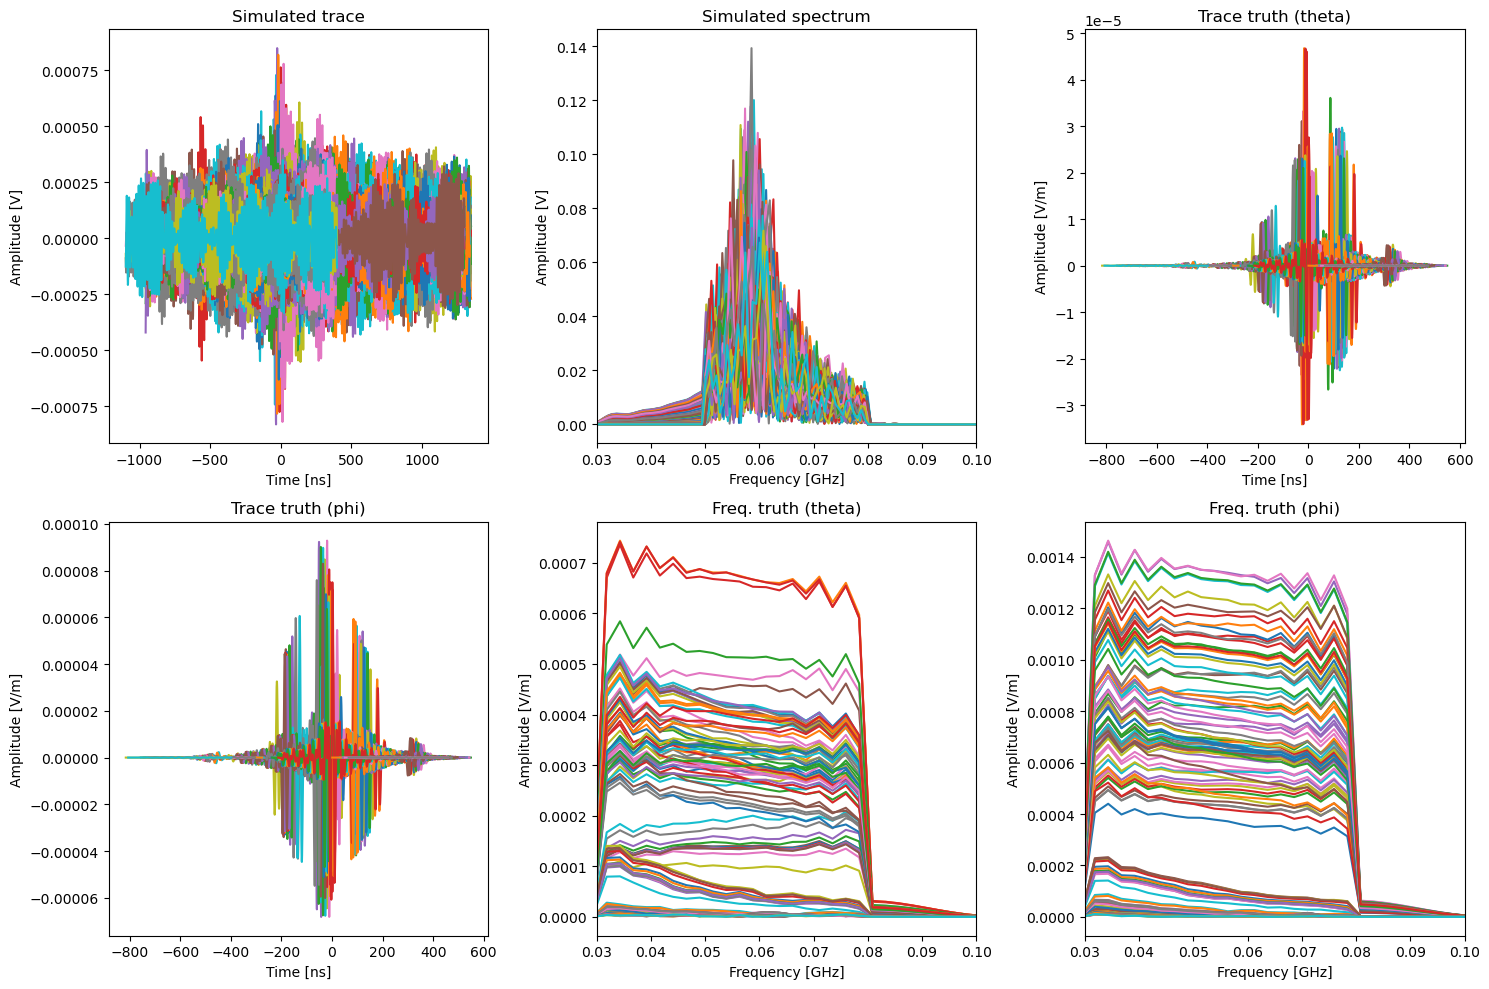

In [2]:
from astropy import time
import numpy as np
import datetime
from matplotlib import pyplot as plt
import os

outdir = os.path.dirname(nur_filename)
if outdir:
    os.makedirs(outdir, exist_ok=True)
    
station_time = time.Time("2025-02-01T00:00:00", format='isot', scale='utc')

for eid, event in enumerate(readCoREASDetector.run(det, core_list, selected_station_channel_ids)):
    eventWriter.begin(f'{nur_filename}_{eid}_raw.nur')
    eventWriter.run(event)
    eventWriter.end()

    for station in event.get_stations():
        ts0 = time.Time.now()
        station.set_station_time(station_time)
        sim_station = station.get_sim_station()
        zenith = sim_station[stationParameters.zenith] 
        azimuth = sim_station[stationParameters.azimuth]

        station.set_parameter(stationParameters.zenith, zenith)
        station.set_parameter(stationParameters.azimuth, azimuth)
        station.set_parameter(stationParameters.triggered, True)
        station.set_is_cosmic_ray()

        print(f"station {station.get_id()}")

        field = sim_station.get_electric_fields()[0]
        print(f"efield trace shape: {field.get_trace().shape}")
        print(f"efield trace_start_time: {field.get_trace_start_time()}")

        t0 = time.Time.now()
        efieldToVoltageConverter.run(event, station, det, channel_ids=selected_station_channel_ids[station.get_id()])
        traces = [channel.get_trace() for channel in station.iter_channels()]
        t1 = time.Time.now()
        print(f"efieldToVoltageConverter took {(t1 - t0).sec} seconds")

        resampler.run(event, station, det, sampling_rate)
        t2 = time.Time.now()
        print(f"channelResampler took {(t2 - t1).sec} seconds")

        if long_trace:
            efields = sim_station.get_electric_fields()
            for e in efields:
                for i in e.get_channel_ids():
                    channel = station.get_channel(i)
                    trace = channel.get_trace()
                    longer_trace = np.zeros(10000)
                    offset = 5000 - len(trace) // 2
                    longer_trace[offset:offset + len(trace)] = trace
                    channel.set_trace(trace=longer_trace, sampling_rate=sampling_rate)
            t_tmp = time.Time.now()
            print(f"preparing long trace took {(t_tmp - t2).sec} seconds")

        excluded_channels = [chid for chid in station.get_channel_ids() if chid not in selected_station_channel_ids[station.get_id()]]
        t31 = time.Time.now()
        channelGalacticNoiseAdder.run(event, station, det, passband=[lowfreq, highfreq], excluded_channels=excluded_channels)
        t32 = time.Time.now()
        print(f"channelGalacticNoiseAdder took {(t32 - t31).sec} seconds")

        channelGenericNoiseAdder.run(
            event, station, det,
            amplitude=6.777 * units.microvolt,
            min_freq=lowfreq,
            max_freq=highfreq,
            type='rayleigh',
            excluded_channels=excluded_channels
        )
        t4 = time.Time.now()
        print(f"channelGenericNoiseAdder took {(t4 - t32).sec} seconds")

        for group_id in station.get_channel_ids(return_group_ids=True):
            converter.run(
                event, station, det,
                use_channels=[channel.get_id() for channel in station.iter_channel_group(group_id)]
            )
        ts1 = time.Time.now()
        print(f"station processing took {(ts1 - ts0).sec} seconds")

    converter.end()

    eventWriter.begin(f'{nur_filename}_{eid}_processed.nur')
    eventWriter.run(event)
    eventWriter.end()

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for station in event.get_stations():
        sim_station = station.get_sim_station()
        print(f"station {station.get_id()}")
        efields = [field for field in sim_station.get_electric_fields() if np.max(np.abs(field.get_trace())) >= 1.0e-10]

        for e in efields:
            for i in e.get_channel_ids():
                channel = station.get_channel(i)
                axs[0].plot(channel.get_times(), channel.get_trace())
                axs[1].plot(channel.get_frequencies(), np.abs(channel.get_frequency_spectrum()))

            axs[2].plot(e.get_times(), e.get_trace()[1])
            axs[3].plot(e.get_times(), e.get_trace()[2])
            axs[4].plot(e.get_frequencies(), np.abs(e.get_frequency_spectrum())[1])
            axs[5].plot(e.get_frequencies(), np.abs(e.get_frequency_spectrum())[2])

    for i in [1, 4, 5]:
        axs[i].set_xlim(lowfreq - 20 * units.MHz, highfreq + 20 * units.MHz)

    titles = ["Simulated trace", "Simulated spectrum", "Trace truth (theta)", "Trace truth (phi)", "Freq. truth (theta)", "Freq. truth (phi)"]
    ylabels = ["Amplitude [V]", "Amplitude [V]", "Amplitude [V/m]", "Amplitude [V/m]", "Amplitude [V/m]", "Amplitude [V/m]"]
    xlabels = ["Time [ns]", "Frequency [GHz]", "Time [ns]", "Time [ns]", "Frequency [GHz]", "Frequency [GHz]"]

    for i in range(6):
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(xlabels[i])
        axs[i].set_ylabel(ylabels[i])

    plt.tight_layout()
    plt.show()


### compare caching and no caching

In [3]:
traces = np.array(traces)
traces_caching = np.copy(traces)

In [4]:
traces = np.array(traces)
traces_nocaching = np.copy(traces)

In [5]:
np.sum(np.abs(traces_caching - traces_nocaching))

0.0

In [6]:
traces.shape

(24, 14660)

In [7]:
lengths = []
for station in event.get_stations():
    sim_station = station.get_sim_station()
    efields = [field for field in sim_station.get_electric_fields()]    
    for efield in efields:
        lengths.append(efield.get_trace().shape[1])

In [8]:
print(f"{890:06}")

000890


In [9]:
station.get_channel_ids()

[181000000,
 181000001,
 181002016,
 181002017,
 181004032,
 181004033,
 181006048,
 181006049,
 181008064,
 181008065,
 181010080,
 181010081,
 181900000,
 181900001,
 181902016,
 181902017,
 181904032,
 181904033,
 181906048,
 181906049,
 181908064,
 181908065,
 181910080,
 181910081]

In [10]:
selected_station_channel_ids[181000000]

KeyError: 181000000

In [11]:
event.get_station(58).get_channel_ids()

KeyError: 58

In [12]:
station = event.get_station(4)

In [13]:
a = True
b = True
a and not b

False

In [14]:
fluences = []
positions = []
for staid in selected_station_channel_ids.keys():
    station = event.get_station(staid)
    try:
        for chid in selected_station_channel_ids[staid]:
            trace = station.get_channel(chid).get_trace()
            fluences.append(np.sum(np.square(trace)))
            positions.append(det.get_absolute_position(staid) + det.get_relative_position(staid, chid))
    except:
        continue

In [15]:
positions = np.array(positions)

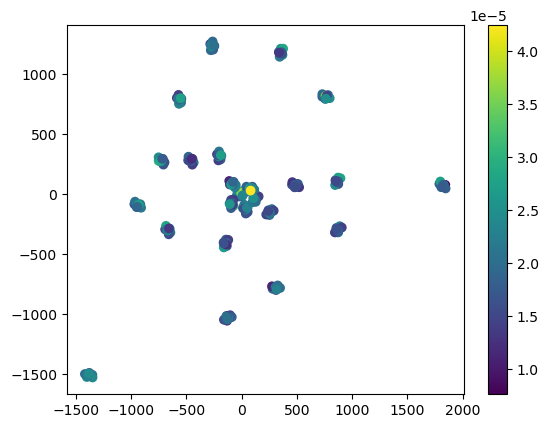

In [16]:
plt.figure()
plt.scatter(positions[:,0][::2], positions[:,1][::2], c=fluences[::2])
plt.colorbar()
plt.show()

In [17]:
len(selected_station_channel_ids.keys())

24

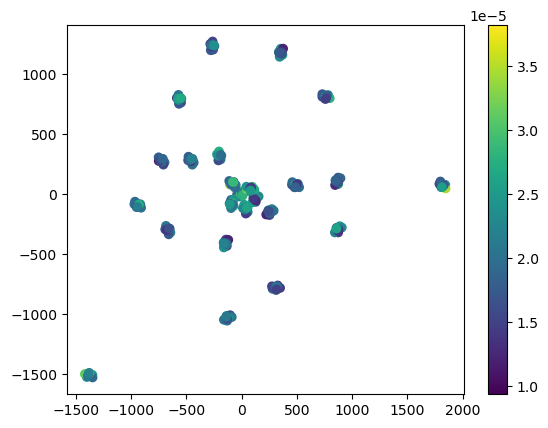

In [18]:
plt.figure()
plt.scatter(positions[:,0][1::2], positions[:,1][1::2], c=fluences[1::2])
plt.colorbar()
plt.show()